In [1]:
print("Hello World!")

Hello World!


In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shutil
import zipfile
import gdown
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [10]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [11]:
!unzip gdrive/MyDrive/Ishan\ Thathsara/TrainingData1.zip

Archive:  gdrive/MyDrive/Ishan Thathsara/TrainingData1.zip
   creating: mid-light/
  inflating: mid-light/augmented_image_7289.jpg  
  inflating: mid-light/augmented_image_7318.jpg  
  inflating: mid-light/augmented_image_736.jpg  
  inflating: mid-light/augmented_image_7365.jpg  
  inflating: mid-light/augmented_image_7403.jpg  
  inflating: mid-light/augmented_image_7407.jpg  
  inflating: mid-light/augmented_image_7426.jpg  
  inflating: mid-light/augmented_image_7436.jpg  
  inflating: mid-light/augmented_image_744.jpg  
  inflating: mid-light/augmented_image_7449.jpg  
  inflating: mid-light/augmented_image_747.jpg  
  inflating: mid-light/augmented_image_750.jpg  
  inflating: mid-light/augmented_image_7503.jpg  
  inflating: mid-light/augmented_image_7504.jpg  
  inflating: mid-light/augmented_image_7507.jpg  
  inflating: mid-light/augmented_image_7509.jpg  
  inflating: mid-light/augmented_image_7519.jpg  
  inflating: mid-light/augmented_image_7600.jpg  
  inflating: mid-ligh

In [12]:
# Define the dataset directory
dataset_dir = '/content'

# Update categories based on actual directory names
categories = ['dark', 'light', 'mid-dark', 'mid-light']

# Create directories for train and validation split
train_dir = '/content/working/train'
valid_dir = '/content/working/val'

for category in categories:
    os.makedirs(os.path.join(train_dir, category), exist_ok=True)
    os.makedirs(os.path.join(valid_dir, category), exist_ok=True)

# Load image paths and labels
image_paths = []
labels = []

for category in categories:
    category_path = os.path.join(dataset_dir, category)
    for img_name in os.listdir(category_path):
        image_paths.append(os.path.join(category_path, img_name))
        labels.append(category)

# Split data into train and validation sets
train_paths, val_paths, train_labels, val_labels = train_test_split(image_paths, labels, test_size=0.2, stratify=labels)

# Move the images to train and validation directories
for img, label in zip(train_paths, train_labels):
    shutil.copy(img, os.path.join(train_dir, label, os.path.basename(img)))

for img, label in zip(val_paths, val_labels):
    shutil.copy(img, os.path.join(valid_dir, label, os.path.basename(img)))

print("Data has been successfully split and organized.")

Data has been successfully split and organized.


In [13]:
# Data augmentation and rescaling
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

valid_datagen = ImageDataGenerator(rescale=1./255)

# Load train and validation data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 160 images belonging to 4 classes.
Found 40 images belonging to 4 classes.


In [14]:
# Load the MobileNetV2 model with pre-trained ImageNet weights
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(len(categories), activation='softmax')(x)  # 4 classes (dark, light, mid-dark, mid-light)

# Define the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 3,573,828 (13.63 MB)

 Trainable params: 1,315,844 (5.02 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [15]:
# Check class indices to ensure 4 classes
print("Class indices:", train_generator.class_indices)
print("Number of classes:", train_generator.num_classes)

Class indices: {'dark': 0, 'light': 1, 'mid-dark': 2, 'mid-light': 3}
Number of classes: 4


In [16]:
# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.3040 - loss: 2.0378 - val_accuracy: 0.3000 - val_loss: 1.8751
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 573ms/step - accuracy: 0.5257 - loss: 1.2640 - val_accuracy: 0.4750 - val_loss: 1.5297
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 689ms/step - accuracy: 0.6234 - loss: 1.1446 - val_accuracy: 0.4750 - val_loss: 1.1484
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 417ms/step - accuracy: 0.7405 - loss: 0.7439 - val_accuracy: 0.5500 - val_loss: 1.0820
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 420ms/step - accuracy: 0.7168 - loss: 0.6759 - val_accuracy: 0.6000 - val_loss: 1.0154
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 617ms/step - accuracy: 0.8111 - loss: 0.5453 - val_accuracy: 0.5250 - val_loss: 0.9474
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 494ms/step - accuracy: 0.8496 - loss: 0.4682 - val_accuracy: 0.5750 - val_loss: 0.9239
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 427ms/step - accuracy: 0.8173 - loss: 0.4524 - val_accuracy: 0.6750 - val_loss: 0

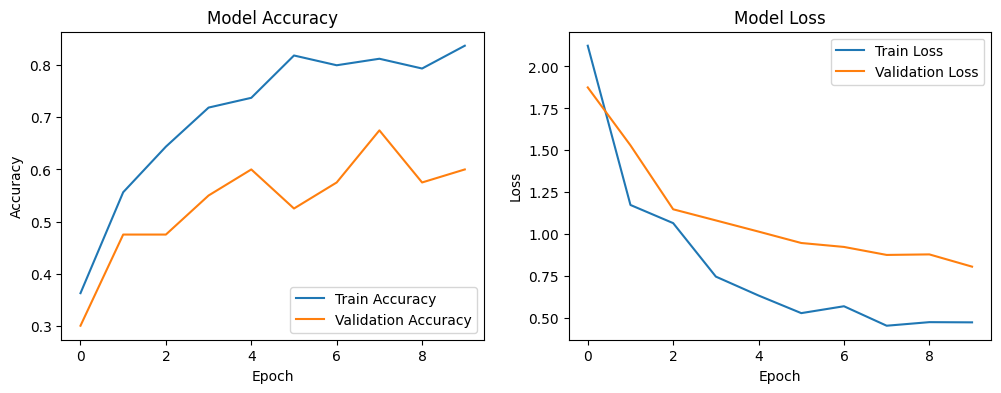

In [17]:
# Plot training & validation accuracy and loss
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.show()

In [18]:
# Evaluate the model on validation data
validation_loss, validation_accuracy = model.evaluate(validation_generator)
print(f"Validation Accuracy: {validation_accuracy * 100:.2f}%")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5979 - loss: 0.7803 
Validation Accuracy: 60.00%


2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 4s/step
Unique predicted classes: [0 1 2 3]
Unique true classes: [0 1 2 3]


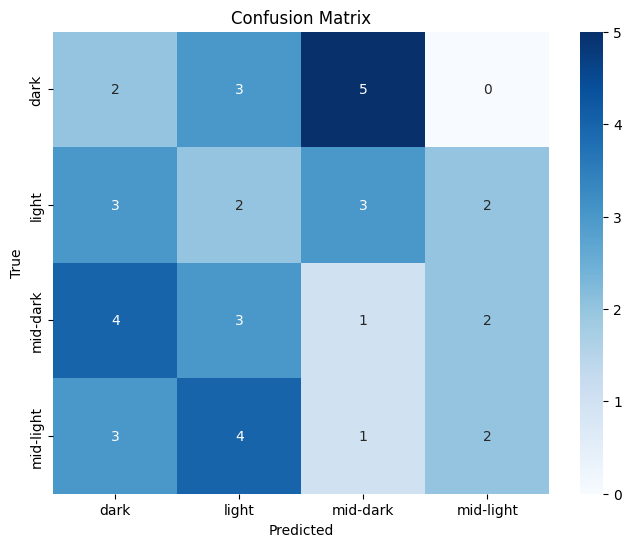

              precision    recall  f1-score   support

        dark       0.17      0.20      0.18        10
       light       0.17      0.20      0.18        10
    mid-dark       0.10      0.10      0.10        10
   mid-light       0.33      0.20      0.25        10

    accuracy                           0.17        40
   macro avg       0.19      0.17      0.18        40
weighted avg       0.19      0.17      0.18        40



In [19]:
# Predict the classes on validation data
Y_pred = model.predict(validation_generator)
y_pred = np.argmax(Y_pred, axis=1)

# Get true classes
y_true = validation_generator.classes

# Check unique predicted and true classes
unique_pred_classes = np.unique(y_pred)
unique_true_classes = np.unique(y_true)

print(f"Unique predicted classes: {unique_pred_classes}")
print(f"Unique true classes: {unique_true_classes}")

# Adjust target names to match actual predicted classes
# This ensures the classification report will reflect only the predicted classes
actual_categories = [categories[i] for i in unique_pred_classes]

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=actual_categories, yticklabels=categories)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification report with adjusted labels
print(classification_report(y_true, y_pred, labels=unique_pred_classes, target_names=actual_categories))